In [1]:
import os

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
import cv2
import matplotlib.pyplot as plt

In [4]:
IMG_HEIGHT = 320
IMG_WIDTH = 320

In [5]:
DIR = '../garbage/garbage_dataset/test/'

In [80]:
model = tf.keras.models.load_model('new_model_0_75')

In [10]:
tf.version.VERSION

'2.3.0'

In [11]:
# model.save('new_model/my_model.h5')

In [111]:
img = np.random.randn(1,IMG_WIDTH,IMG_HEIGHT,3).astype(np.float32)

In [ ]:
%%timeit
out = model.predict(img)

In [14]:
def mask_garbage(fpath, show=True, save=False, out_path='', resize=True):
    img = cv2.imread(fpath)
    if resize:
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255
    pred = model.predict(np.expand_dims(img,0)).squeeze()
    mask = cv2.resize(pred*255, img.shape[1::-1])/255
    plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4)#, cmap='PuRd')
    if save:
        fnm = fp.split('/')[-1].split('.')[0]
        plt.savefig(out_path + fnm + '.png', bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close()
    plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(mask)
    plt.close()

In [ ]:
for fp in os.listdir(DIR)[60:70]:
    mask_garbage(DIR+fp, show=True, save=False, resize=True)

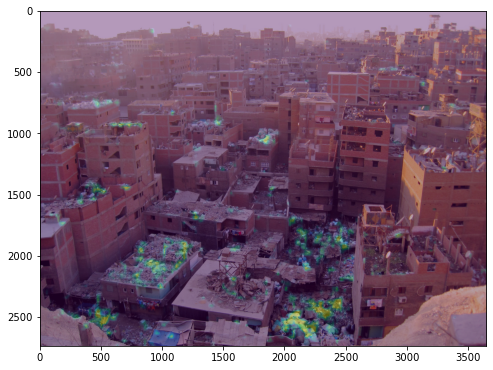

In [17]:
mask_garbage(DIR+'../train/3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg', show=True, resize=False)

In [208]:
finp = tf.keras.layers.Input(shape=(640,640,3))

In [209]:
fmodel = tf.keras.models.Sequential([finp, model])

In [210]:
fmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, None, None, 1)     712441    
Total params: 712,441
Trainable params: 702,761
Non-trainable params: 9,680
_________________________________________________________________


In [211]:
converter = tf.lite.TFLiteConverter.from_keras_model(fmodel)

In [212]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [213]:
# # For full integer quantization, you need to measure the dynamic range of activations and inputs by supplying
# # sample input data to the converter.
# def representative_dataset_gen():
#     for _ in range(num_calibration_steps):
#         # Get sample input data as a numpy array in a method of your choosing.
#         yield [input]
# converter.representative_dataset = representative_dataset_gen

In [214]:
converter.target_spec.supported_types = [tf.float32] # [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [215]:
# Full integer for coral edge
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

In [216]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcw18idnj/assets


INFO:tensorflow:Assets written to: /tmp/tmpcw18idnj/assets


In [6]:
tflite_path = 'new_model_0_75/my_model_fp32_640x640.tflite'

In [7]:
# with open(tflite_path, 'wb') as f:
#     f.write(tflite_model)

# Steps to run are below

In [8]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_path)

In [9]:
tflite_interpreter.allocate_tensors()

In [10]:
tflite_input_details = tflite_interpreter.get_input_details()
tflite_input_details

[{'name': 'input_4',
  'index': 0,
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [11]:
tflite_output_details = tflite_interpreter.get_output_details()
tflite_output_details

[{'name': 'Identity',
  'index': 331,
  'shape': array([ 1, 40, 40,  1], dtype=int32),
  'shape_signature': array([-1, 40, 40,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [12]:
IMG_HEIGHT = 640
IMG_WIDTH = 640

In [6]:
img = cv2.imread(DIR+'../train/3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg')
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img = img/255#127.5 - 1

In [14]:
tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))

In [15]:
tflite_interpreter.invoke()

In [16]:
out = tflite_interpreter.get_tensor(tflite_output_details[0]['index'])

In [17]:
from time import time

In [20]:
tot = 0
frames = 100
start = time()
for i in range(frames):
    tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))
    tflite_interpreter.invoke()
    out = tflite_interpreter.get_tensor(tflite_output_details[0]['index'])
#     model(np.expand_dims(img, axis=0), training=False)
tot = time()-start
print(frames/tot)

11.594510902874093


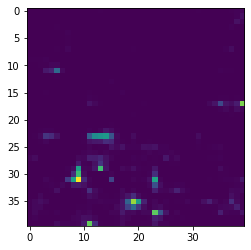

In [19]:
plt.imshow(out.squeeze())

# TRAIN ON ALL BACKGROUNDS
# AND CROSS ENTROPY FROM LOGITS

In [34]:
cam = cv2.VideoCapture('../garbage_detection/drone3.mp4')
fps = 30#round(cam.get(cv2.CAP_PROP_FPS))
writer = cv2.VideoWriter('dout3.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps,(IMG_WIDTH,IMG_HEIGHT))

In [35]:
cv2.namedWindow("output", cv2.WINDOW_NORMAL)
cv2.resizeWindow("output", 600,600)
while cam.isOpened():
    ret, img = cam.read()
    if not ret:
        print("video finished.")
        break
    oimg = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     cv2.imshow("output",oimg)
    img = cv2.cvtColor(oimg, cv2.COLOR_BGR2RGB).astype(np.float32)
    img/= 255
    tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))
    tflite_interpreter.invoke()
    pred = tflite_interpreter.get_tensor(tflite_output_details[0]['index']).squeeze()
#     pred[pred<0.9] = 0
    pred = (pred*255).astype(np.uint8)
    mask = cv2.resize(pred, img.shape[1::-1])
#     mult = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)*img
    heatmap_img = cv2.applyColorMap(mask, cv2.COLORMAP_HOT)
    heated = cv2.addWeighted(heatmap_img, 0.3, oimg, 1, 0)
    cv2.imshow("output", heated)
    writer.write(heated)
    key = cv2.waitKey(1) & 0xff
    if key == ord('q'):
        break
cv2.destroyAllWindows()

video finished.


In [36]:
writer.release()
cam.release()

In [29]:
cv2.destroyAllWindows()